## _STT HitPairs_

1. **_prepare data_**:_`hitpairs`_
2. **_data input pipeline_**:_`tf.data.Dataset`_
3. **_functional/subclassing api_**:_`tf.keras.Model`_
4. **_fitted/custom training loops_**:_`tf.keras.Model.fit`/`GradientTape`_

### _5. Predict Model_

In [1]:
import sys, os, glob, yaml
sys.path.append('src')

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook, tnrange
from sklearn.model_selection import train_test_split

import tensorflow as tf
import trackml.dataset

%matplotlib inline

In [3]:
from dutils import load_event_hits, load_event, get_event
from models import HitPairsANNS_TrackML_Small
from drawing import draw_train_history, draw_single_event
from pairs import construct_pairs, construct_pairs_hard

In [4]:
# tf.keras.backend.set_floatx('float64')

### _Configs (YAML)_

In [5]:
# load config
with open('configs/prep_stt.yaml') as f:
    config = yaml.safe_load(f)
    
# get data
input_dir = os.path.expandvars(config['input_dir'])
print(input_dir)

/home/adeel/current/data_sets/pandaml/data-3-7-GeV/


### _Event Vizualization_

In [6]:
def display_event(path="", event_id=1):
    prefix = path + str('event{!s}'.format(format(event_id, '010d')))
    hits = load_event_hits(prefix)
    draw_single_event(event=hits, event_id=event_id, figsize=(8, 8));

In [7]:
# display_event(input_dir, 1)

### _Input Pipeline_

In [9]:
# prepare data (three version slightly different)
X, y = construct_pairs(path=input_dir, start=0, end=100)
# X, y = prepare_pairs(path=input_dir, start=0, end=100)
# X, y = prepare_pairs_list(path=input_dir, start=0, end=100)

processing  event0000000000
processing  event0000000010
processing  event0000000020
processing  event0000000030
processing  event0000000040
processing  event0000000050
processing  event0000000060
processing  event0000000070
processing  event0000000080
processing  event0000000090



In [10]:
X.shape, y.shape

((1990341, 8), (1990341, 1))

In [11]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [13]:
# make tf.data.Dataset object from numpy for training and testing
batch_size = 1024
trainset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size)
testset= tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

## _4 - Testing Model_

- directly start at testing.

In [36]:
try:
    model
except NameError:
    print('load model')
    model = load_model('saved/sol2_stt_hard.h5')

In [82]:
event = 'event0000000998'
hits, truth, particles, tubes = get_event(input_dir, event)
features = hits[['x','y', 'isochrone', 'energyloss']].values

In [83]:
features.shape

(218, 4)

In [84]:
hits.head()

,hit_id,x,y,z,tube_id,skewed,layer_id,sector_id,volume_id,isochrone,depcharge,energyloss,particle_id
0,1,11.3709,-12.625,35.0,63,0,0,3,9,0.320492,6002540.0,6.00254,10
1,2,11.3709,-13.635,35.0,170,0,1,3,9,0.340076,5132340.0,5.13234,10
2,3,12.2456,-14.140,35.0,284,0,2,3,9,0.020575,6378750.0,6.37875,10
3,4,13.1203,-14.645,35.0,404,0,3,3,9,0.346437,3138190.0,3.13819,10
4,5,13.1203,-15.655,35.0,529,0,4,3,9,0.339190,3848680.0,3.84868,10


In [85]:
gl = hits.groupby(['layer_id'])

In [86]:
gl.first()

,hit_id,x,y,z,tube_id,skewed,sector_id,volume_id,isochrone,depcharge,energyloss,particle_id
layer_id,,,,,,,,,,,,
0,1,11.3709,-12.6250,35.0,63,0,3,9,0.320492,6002540.0,6.002540,10
1,2,11.3709,-13.6350,35.0,170,0,3,9,0.340076,5132340.0,5.132340,10
2,3,12.2456,-14.1400,35.0,284,0,3,9,0.020575,6378750.0,6.378750,10
3,4,13.1203,-14.6450,35.0,404,0,3,9,0.346437,3138190.0,3.138190,10
4,5,13.1203,-15.6550,35.0,529,0,3,9,0.339190,3848680.0,3.848680,10
5,6,13.9950,-16.1600,35.0,661,0,3,9,0.024166,4816550.0,4.816550,10
6,7,14.8697,-16.6650,35.0,799,0,3,9,0.273951,5641660.0,5.641660,10
7,8,14.8697,-17.6750,35.0,942,0,3,9,0.357550,10962500.0,10.962500,10
8,9,14.1402,-19.2624,35.0,1107,1,3,9,0.257329,5846030.0,5.846030,10


In [87]:
hits_l = gl.get_group(1)
hits_l

,hit_id,x,y,z,tube_id,skewed,sector_id,volume_id,isochrone,depcharge,energyloss,particle_id
1,2,11.37090,-13.635,35.0,170,0,3,9,0.340076,5132340.0,5.13234,10
27,28,-12.24560,-13.130,35.0,148,0,2,9,0.106919,6279750.0,6.27975,9
52,53,-3.49874,18.180,35.0,106,0,0,9,0.063656,14199500.0,14.19950,8
100,101,-13.99500,-12.120,35.0,146,0,2,9,0.146736,11776100.0,11.77610,5
124,125,-10.49620,14.140,35.0,114,0,0,9,0.401445,5568200.0,5.56820,4
150,151,17.49370,-10.100,35.0,177,0,3,9,0.253959,9523180.0,9.52318,3
170,171,-5.24811,-17.170,35.0,156,0,2,9,0.457208,3383540.0,3.38354,2
195,196,17.49370,7.070,35.0,194,0,4,9,0.159199,7719420.0,7.71942,1


In [93]:
# single column is a Series
hits_l['hit_id']

1        2
27      28
52      53
100    101
124    125
150    151
170    171
195    196
Name: hit_id, dtype: int64

In [94]:
# let count the number of hits
hits_l['hit_id'].count()

8

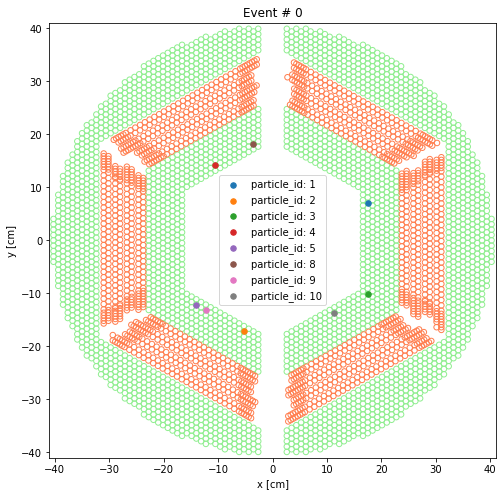

In [95]:
draw_single_event(event=hits_l, event_id=0, figsize=(8, 8));

In [98]:
count = hits.groupby(['layer_id'])['hit_id'].count().values

In [99]:
len(count)

26

In [ ]:
# Get an event:
event = 'event000001001'
hits, cells, truth, particles = get_event(event)
hit_cells = cells.groupby(['hit_id']).value.count().values
hit_value = cells.groupby(['hit_id']).value.sum().values
features = np.hstack((hits[['x','y','z']]/1000, hit_cells.reshape(len(hit_cells),1)/10,hit_value.reshape(len(hit_cells),1)))
count = hits.groupby(['volume_id','layer_id','module_id'])['hit_id'].count().values
module_id = np.zeros(len(hits), dtype='int32')

for i in range(len(count)):
    si = np.sum(count[:i])
    module_id[si:si+count[i]] = i